In [278]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA


In [ ]:
USER_ID = 'Priyatham Katta'
CLIENT_ID = 'd92bb818908d43a0b0f76b11998f5f21'
CLIENT_SECRET = 'd0b49d986d4646f59e4633833cf88ffc'

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)) 

uris = {    '2018':'spotify:playlist:37i9dQZF1DX1HUbZS4LEyL', 
            '2019':'spotify:playlist:37i9dQZF1DXcz8eC5kMSWZ', 
            'decade':'spotify:playlist:37i9dQZF1DWYJ5kmTbkZiz'}



In [102]:
def playlist_df(playlist):

    df = pd.DataFrame(columns=['title','artist','album','year','explicit','uri','danceability', 'energy', 
                                'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                                'liveness', 'valence', 'tempo', 'duration_s'])
    
    title, artist, album, explicit, uri, year, popularity = [], [], [], [], [], [], []
    danceability, energy, key, loudness, mode = [], [], [], [], []
    speechiness, acousticness, liveness, valence, tempo, duration_s = [], [], [], [], [], []

    for i in tqdm(range(len(playlist))):
        title.append(playlist[i]['track']['name'])
        artist.append(playlist[i]['track']['artists'][0]['name'])
        album.append(playlist[i]['track']['album']['name'])
        date = playlist[i]['track']['album']['release_date']
        try:
            year.append(str(datetime.strptime(date, '%Y-%m-%d').year))
        except:
            year.append(date)
        popularity.append(playlist[i]['track']['popularity'])
        explicit.append(playlist[i]['track']['explicit'])
        uri.append(playlist[i]['track']['uri'])
        
        retrieve_feature = sp.audio_features(playlist[i]['track']['uri'])[0]
        
        danceability.append(retrieve_feature['danceability'])
        energy.append(retrieve_feature['energy'])
        key.append(retrieve_feature['key'])
        loudness.append(retrieve_feature['loudness'])
        mode.append(retrieve_feature['mode'])
        speechiness.append(retrieve_feature['speechiness'])
        acousticness.append(retrieve_feature['acousticness'])
        liveness.append(retrieve_feature['liveness'])
        valence.append(retrieve_feature['valence'])
        tempo.append(retrieve_feature['tempo'])
        duration_s.append(round(retrieve_feature['duration_ms']/1000))
        
    df['title'], df['artist'], df['album'],df['year'], df['popularity'], df['explicit'] = title, artist, album, year, popularity, explicit
    df['uri'], df['danceability'], df['energy'], df['key'] = uri, danceability, energy, key
    df['loudness'], df['mode'], df['speechiness'], df['acousticness'] = loudness, mode, speechiness, acousticness
    df['liveness'], df['valence'], df['tempo'], df['duration_s'] = liveness, valence, tempo, duration_s
    
    return df


In [ ]:
top_tracks_pl = []

for k,v in uris.items():
    top_tracks_pl.append(sp.user_playlist(USER_ID, v)['tracks']['items'])


In [103]:
playlist_dfs = []
for playlist in top_tracks_pl:
    playlist_dfs.append(playlist_df(playlist))


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  8.29it/s]


In [104]:
tracks_df = pd.concat([pd.DataFrame(df) for df in playlist_dfs])


In [150]:
tracks_df.drop_duplicates(subset=['artist','uri'],inplace=True)

In [176]:
#Converting key from numerical to Tonal Counterparts
key_map = {0:'C',1:'C-sharp',2:'D',3:'D-sharp',4:'E',5:'F',6:'F-sharp',7:'G',8:'G-sharp',9:'A',10:'A-sharp',11:'B'}
tracks_df['key'] = tracks_df['key'].apply(lambda x:key_map[x])

In [186]:
tracks_df['year'] = tracks_df['year'].apply(lambda x: x if x in ['2019','2018','2017'] else 'Decade')

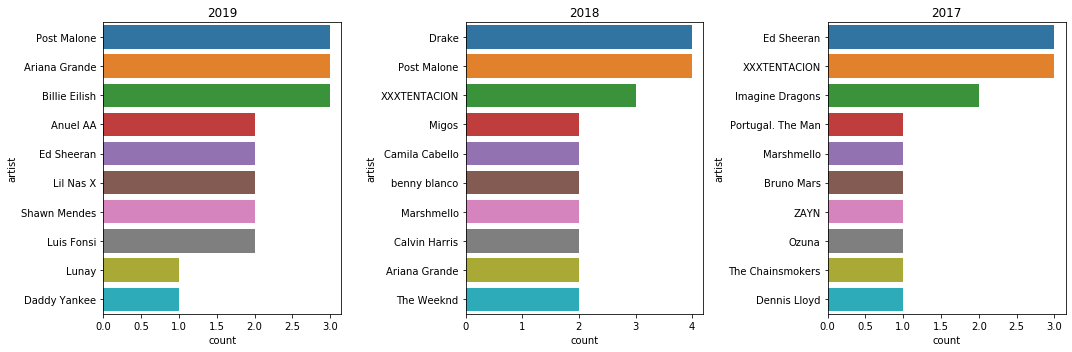

In [314]:
from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

years = ['2019','2018','2017']
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))

for i,year in enumerate(years):
    axs[i].title.set_text(year)

    sns.countplot(y = 'artist',
                  data = tracks_df[tracks_df['year']==year],
                  order = tracks_df[tracks_df['year']==year]['artist'].value_counts()[:10].index,
                  orient = 'h',
                 ax=axs[i])

fig.tight_layout()


<h4>Here are the top 10 artists of the decade.<br><br>
Post Malone is the artist with most Trending songs in the 2019 and 2018.</h4>


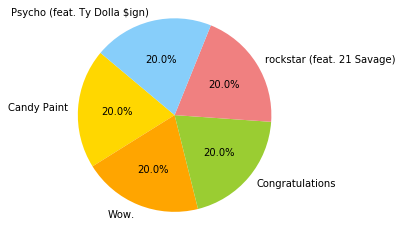

In [315]:
top_artist = tracks_df.loc[tracks_df['artist'] == 'Post Malone']
colors = ['gold', 'orange','yellowgreen', 'lightcoral', 'lightskyblue']
top = top_artist['title'].value_counts()[:5].index.tolist()
value =top_artist['title'].value_counts()[:5].values.tolist()
plt.pie(value, labels=top, colors=colors, autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.show()


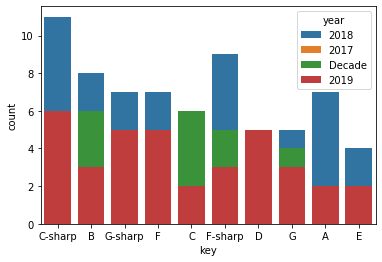

In [317]:

sns.countplot(x = 'key',
              data = tracks_df,
              order = tracks_df['key'].value_counts()[:10].index,
              hue = 'year',
              dodge=False
                 )


<h4>C-sharp key is being used more in recent times making them popular.</h4>
<h4>From Lewis Capaldi’s Someone You Loved to Drake's In My Feelings, composed in C# scale.</h4>


In [318]:
tracks_df[tracks_df['key']=='C-sharp'].sort_values('popularity',ascending=False)[:6]

,title,artist,album,year,explicit,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_s,popularity
7,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019,False,spotify:track:7qEHsqek33rTcFNT9PFqLf,0.501,0.405,C-sharp,-5.679,1,0.0319,0.7510,0.1050,0.446,109.891,182,93
3,7 rings,Ariana Grande,"thank u, next",2019,True,spotify:track:6ocbgoVGwYJhOv1GgI9NsF,0.778,0.317,C-sharp,-10.732,0,0.3340,0.5920,0.0881,0.327,140.048,179,88
14,Sucker,Jonas Brothers,Happiness Begins,2019,False,spotify:track:22vgEDb5hykfaTwLuskFGD,0.842,0.734,C-sharp,-5.065,0,0.0588,0.0427,0.1060,0.952,137.958,181,86
15,Sweet but Psycho,Ava Max,Sweet but Psycho,2018,False,spotify:track:25sgk305KZfyuqVBQIahim,0.719,0.704,C-sharp,-4.724,1,0.0476,0.0691,0.1660,0.628,133.002,187,85
13,"thank u, next",Ariana Grande,"thank u, next",2019,True,spotify:track:3e9HZxeyfWwjeyPAMmWSSQ,0.717,0.653,C-sharp,-5.634,1,0.0658,0.2290,0.1010,0.412,106.966,207,85
25,Shape of You,Ed Sheeran,÷ (Deluxe),2017,False,spotify:track:7qiZfU4dY1lWllzX7mPBI3,0.825,0.652,C-sharp,-3.183,0,0.0802,0.5810,0.0931,0.931,95.977,234,85


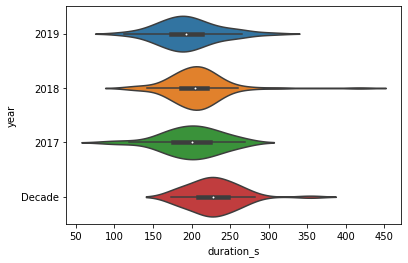

In [244]:
sns.violinplot(x='duration_s', y='year', data=tracks_df,order=['2019','2018','2017','Decade'])

<h4>We observe 2018 has slightly more number of songs with longer duration compared to years 2019,2017 and rest of decade.<br><br> Te Bote by Nio Gracia has duration of almost 7 minutes</h4>


In [249]:
tracks_df[tracks_df['year']=='2018'].sort_values('duration_s',ascending=False)[:3]

,title,artist,album,year,explicit,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,duration_s,popularity
21,Te Boté - Remix,Nio Garcia,Te Boté (Remix),2018,True,spotify:track:3V8UKqhEK5zBkBb6d6ub8i,0.903,0.675,B,-3.445,0,0.214,0.54200,0.0595,0.442,96.507,418,79
42,SICKO MODE,Travis Scott,ASTROWORLD,2018,True,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.834,0.730,G-sharp,-3.714,1,0.222,0.00513,0.1240,0.446,155.008,313,86
73,Walk It Talk It,Migos,Culture II,2018,True,spotify:track:6n4U3TlzUGhdSFbUUhTvLP,0.907,0.633,D,-5.145,1,0.184,0.08760,0.1060,0.395,145.914,276,77


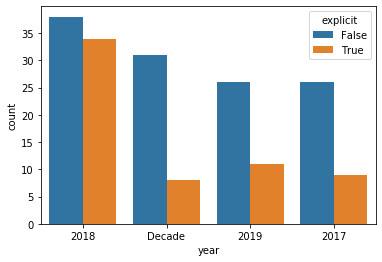

In [258]:

sns.countplot(x = 'year',
              data = tracks_df,
              order = tracks_df['year'].value_counts().index,
              hue = 'explicit',
              dodge=True,
                 )

<h4>In 2018 The explicit tracks stand level with the non-explicit ones.</h4>

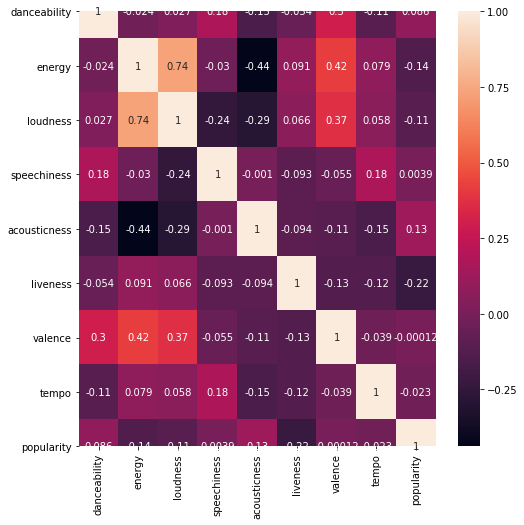

In [319]:

req_features = ['danceability','energy','loudness','speechiness','acousticness','liveness','valence','tempo','popularity']
plt.figure(figsize=(8, 8))
sns.heatmap(tracks_df[req_features].corr(), annot=True)
# tracks_df[req_features]

<h4>It seems like energy and loudness are highly positively correlated.<br><br>
Also, valence is positively correlated with danceability and energy.<br><br> Considering happy songs make people energetic and want to dance, the correlation make a lot sense.</h4>


Text(0, 0.5, 'Density')

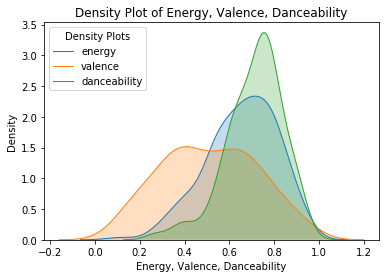

In [320]:
plots = ['energy','valence','danceability']
for plot in plots:
    sns.distplot(tracks_df[plot], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1},
                 label = plot)
    
# Plot formatting
plt.legend(prop={'size': 10}, title = 'Density Plots')
plt.title('Density Plot of Energy, Valence, Danceability')
plt.xlabel('Energy, Valence, Danceability')
plt.ylabel('Density')


<h4>As it can be seen on the graph, since these variables are positively correlated and have limited between (0,1), the distribution of these variables look similar to each other.</h4>

